# Class prior estimation methods

Cost-sensitive approaches crucially rely on the knowledge of outcome prior $\pi$, which might have a large impact on the quality of the recommendations. $y \in \{−1, 0, 1\}$ are the accessible labels. Let us denote $s \in \{−1, 1\}$ the true labels, and $v$ is the feature vector. Under the usual assumptions made in Positive-Unlabeled (PU) learning:
$$\pi := \mathbb{P}(s = 1)\;.$$

**benchscofi** provides implementations of several class prior estimation methods, shown below. We will test their performance on a randomly generated subset, resp. on real-life drug repurposing datasets.

In [1]:
from importlib import reload
import stanscofi.datasets
import stanscofi.utils
import numpy as np

import sys
sys.path.insert(0,"src/")

import benchscofi
import benchscofi.utils
from benchscofi.utils import prior_estimation

rseed=12345

/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-11 13:25:31.978705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 13:25:34.114351: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. Datasets

### 1.1 Randomly generated PU dataset, with exactly known true $\pi$

#####  Censoring setting

Assume that $s \in \{-1,1\}$ are the true labels, $y \in \{0,1\}$ are the accessible labels (note that accessible negative samples are missing), and $v \in \mathbb{R}^d$ are the feature vectors. Samples $(v,s) \sim p(v,s)$, and then are made accessible as follows $y \sim p(\cdot \mid v, s=1)$ and $\mathbb{P}(y \neq 0 \mid v, s=-1) = p(y=-1 \mid v, s=1) = 0$.

##### Case-Control setting

Assume that $s \in \{-1,1\}$ are the true labels, $y \in \{-1,0,1\}$ are the accessible labels, and $v \in \mathbb{R}^d$ are the feature vectors. Positive pairs $v \sim p_+ = p(\cdot | y=+1)$, negative pairs $v \sim p_- = p(\cdot | y=-1)$, and unlabeled pairs $v \sim p_u = \pi p_+ + (1-\pi)p_-$ (where $\pi := \mathbb{P}(s = 1) \in (0,1)$ is the class-prior probability).

##### SCAR assumption [1] (for the censoring setting)

$$c := \mathbb{P}(y \neq 0 | s=1) = \mathbb{P}(y \neq 0 | v, s=1) = \text{cst}\;.$$

##### Invariance of order [2] (for the case-control setting)

$$\forall v, v' \in \mathbb{R}^d, \ \mathbb{P}(s = 1 \mid v) \leq \mathbb{P}(s = 1 \mid v') \Leftrightarrow \mathbb{P}(y= 1 \mid v) \leq \mathbb{P}(y=1 \mid v')\;.$$

**[1]** Elkan, Charles, and Keith Noto. "Learning classifiers from only positive and unlabeled data." Proceedings of the 14th ACM SIGKDD international conference on Knowledge discovery and data mining. 2008.

**[2]** Kato, Masahiro, Takeshi Teshima, and Junya Honda. "Learning from positive and unlabeled data with a selection bias." International conference on learning representations. 2018.

In [2]:
import pandas as pd

def print_naive_estimators(dataset, labels_mat, true_args):
    pos_known = np.sum(dataset.ratings[:,2]>0)/dataset.ratings.shape[0]
    pos_total = np.sum(dataset.ratings_mat>0)/np.prod(dataset.ratings_mat.shape)
    known_total = np.sum(dataset.ratings_mat!=0)/np.prod(dataset.ratings_mat.shape)
    pos_unk = np.sum(dataset.ratings_mat>0)/np.sum(dataset.ratings_mat==0)
    pos_known_true = np.nan if(labels_mat is None) else np.sum(labels_mat.values>0)/np.prod(labels_mat.values.shape)
    return pd.DataFrame(
        [
            [true_args[arg] for arg in true_args]
            +[pos_known, known_total, pos_unk, pos_known_true, 
              pos_total/true_args["pi"] if ("pi" in true_args) else np.nan, 
              pos_total/pos_known_true if (labels_mat is not None) else np.nan]
        ],
        columns=[arg for arg in true_args]+["#Pos/#Known", "#Known/#Total~sparsity", "#Pos/#Unk", 
                "#Pos/#Known(true)~pi", "#Pos/(#Total*pi)~c", "(#Pos/#Total)/(#Pos/#Known(true))~c"],
        index=["Value"],
    )

synthetic_params = {
    "N":10000, "nfeatures":100, "mean":2, "std":0.1, "exact": True, "random_state": rseed,
}

#### 1.1.a  Censoring setting

Generate a synthetic dataset which matches the specifications of the censoring setting. In that setting, there are only positive ($y=1$) and unlabeled ($y=0$) samples (*i*.*e*., all negative samples are unlabeled). Note that
$$c \pi = \mathbb{P}(y=1 \mid s=1)\mathbb{P}(s=1) = \mathbb{P}(y=1)-\underbrace{\mathbb{P}(y=1 \mid s=-1)}_{=0}\mathbb{P}(s=-1)\;.$$

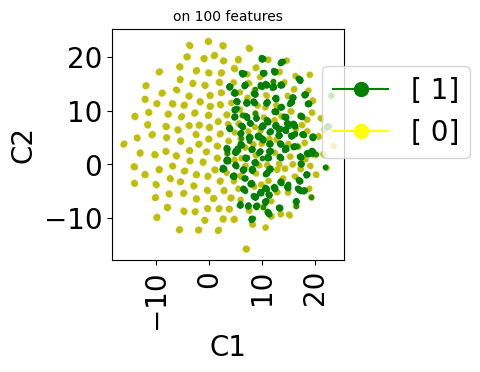

----------------------------------------------------------------------
* Matching matrix:
Ratings: 50 drugs	101 diseases involved in at least one known matching
2020 positive, 0 negative, 8181 unknown matchings
Sparsity for drugs/diseases involved in at least one known matching: 19.80 perc.
-----------------------------------
* Feature matrices:
Total #Drugs: 101	#Drug features: 50	Perc. Missing features: 0
Total #Diseases: 101	#Disease features: 50	Perc. Missing features: 0
----------------------------------------------------------------------



,pi,c,#Pos/#Known,#Known/#Total~sparsity,#Pos/#Unk,#Pos/#Known(true)~pi,#Pos/(#Total*pi)~c,(#Pos/#Total)/(#Pos/#Known(true))~c
Value,0.5,0.4,1.0,0.19802,0.246914,0.49505,0.39604,0.4


In [3]:
reload(benchscofi.utils.prior_estimation)
from benchscofi.utils.prior_estimation import generate_Censoring_dataset

true_args_censoring = {"pi": 0.5, "c":0.4}
censoring_params = {}
censoring_params.update(true_args_censoring)
censoring_params.update(synthetic_params)

censoring_di, labels_mat = generate_Censoring_dataset(**censoring_params)
censoring_dt = stanscofi.datasets.Dataset(**censoring_di)
censoring_dt.visualize(withzeros=True, figsize=(3,3), dimred_args={"n_neighbors": 10})

censoring_dt.summary()

print_naive_estimators(censoring_dt, labels_mat, true_args_censoring)
## pi ~ #pos/#total in the true labels matrix which is OK
## c ~ (#pos/#total)/pi in the ratings matrix which is OK

#### 1.1.b  Case-Control setting

This setting allows negative samples to be accessible.

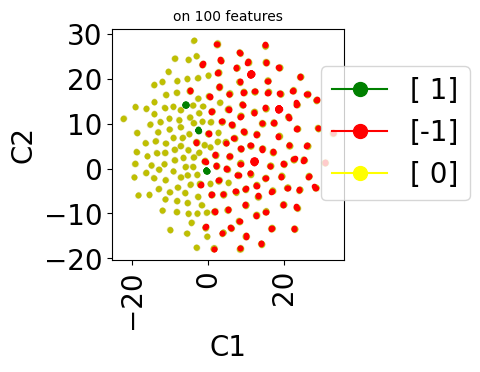

----------------------------------------------------------------------
* Matching matrix:
Ratings: 100 drugs	100 diseases involved in at least one known matching
87 positive, 504 negative, 9409 unknown matchings
Sparsity for drugs/diseases involved in at least one known matching: 5.91 perc.
-----------------------------------
* Feature matrices:
Total #Drugs: 100	#Drug features: 50	Perc. Missing features: 0
Total #Diseases: 100	#Disease features: 50	Perc. Missing features: 0
----------------------------------------------------------------------



,pi,sparsity,#Pos/#Known,#Known/#Total~sparsity,#Pos/#Unk,#Pos/#Known(true)~pi,#Pos/(#Total*pi)~c,(#Pos/#Total)/(#Pos/#Known(true))~c
Value,0.3,0.05,0.147208,0.0591,0.009246,0.29,0.029,0.03


In [5]:
reload(benchscofi.utils.prior_estimation)
from benchscofi.utils.prior_estimation import generate_CaseControl_dataset

true_args_casecontrol = {"pi": 0.3, "sparsity": 0.05}
casecontrol_params = {}
casecontrol_params.update(true_args_casecontrol)
casecontrol_params.update(synthetic_params)

casecontrol_di, labels_mat = generate_CaseControl_dataset(**casecontrol_params)
casecontrol_di.update({"name": "casecontrol"})
casecontrol_dt = stanscofi.datasets.Dataset(**casecontrol_di)
casecontrol_dt.visualize(withzeros=True, figsize=(3,3), dimred_args={"n_neighbors": 10})

casecontrol_dt.summary()

print_naive_estimators(casecontrol_dt, labels_mat, true_args_casecontrol)
## pi ~ #pos/#total in the true labels matrix which is OK
## sparsity ~ #known/#total in the ratings matrix which is OK

### 1.2 Real-life drug repurposing dataset (unknown $\pi$)

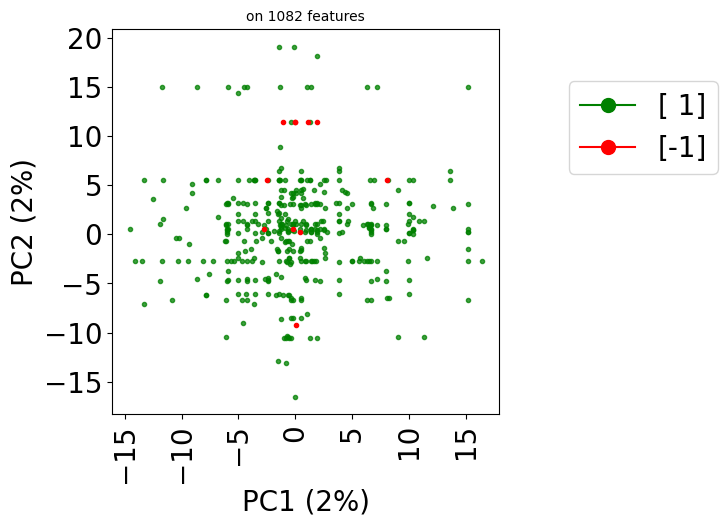

,#Pos/#Known,#Known/#Total~sparsity,#Pos/#Unk,#Pos/#Known(true)~pi,#Pos/(#Total*pi)~c,(#Pos/#Total)/(#Pos/#Known(true))~c
Value,0.973301,0.004451,0.004352,NaN,NaN,NaN


In [3]:
dataset_name="TRANSCRIPT"
dataset_folder="datasets/"

data_args = stanscofi.utils.load_dataset(dataset_name, dataset_folder)
real_dataset = stanscofi.datasets.Dataset(**data_args)

real_dataset.visualize(withzeros=False)
print_naive_estimators(real_dataset, None, {})

## 2. Class prior estimation methods relying on a pretrained classifier

### 2.1 Train a classifier

We also generate a validation dataset which is produced in the same fashion as the training dataset.

In [6]:
from stanscofi.validation import compute_metrics, plot_metrics
from stanscofi.preprocessing import preprocessing_routine
#from stanscofi.training_testing import traintest_validation_split
from sklearn.model_selection import cross_validate ## works when no PU learning...
from sklearn.model_selection import StratifiedKFold ## otherwise we end up with single-class batches
from sklearn.metrics import roc_auc_score

from stanscofi.models import create_scores
from sklearn.svm import SVC ## SVM alone dies on PU learning (as expected)
#from benchscofi.PulearnWrapper import PulearnWrapper
from pulearn import ElkanotoPuClassifier ## let's be conservative and directly use the implementation in pulearn

def train_classifier(dataset, test_size=0.2, show_plots=False):
    ## Model parameters: basic SVM
    #model = SVC(C=5., kernel='rbf', gamma=0.5, probability=True, random_state=rseed)
    ## Model parameters: PU learn
    model = ElkanotoPuClassifier(**{
                "estimator": SVC(C=10, kernel='rbf', gamma=0.4, probability=True),
                "hold_out_ratio": 0.2,
            })
    
    ## Random split
    from sklearn.model_selection import train_test_split
    X = np.array([[j,i] for i,j in np.argwhere(np.ones(dataset.ratings_mat.shape))])
    y = dataset.ratings_mat.ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                            random_state=rseed, shuffle=True, stratify=y)
    train_set = np.asarray(np.concatenate((X_train, y_train.reshape(-1,1)),axis=1), dtype=int)
    test_set = np.asarray(np.concatenate((X_test, y_test.reshape(-1,1)),axis=1), dtype=int)
    train_dataset = dataset.get_folds(train_set)
    test_dataset = dataset.get_folds(test_set)
    
    ## Preprocessing and fitting on the training set
    X_train, y_train, _,_,_ = preprocessing_routine(train_dataset, "meanimputation_standardize")
    #model.fit(X_train,y_train) ## it overfits (as expected)
    ## K-fold Cross-validation (to avoid overfitting)
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scores = cross_validate(model, X_train, y_train, cv=5, scoring='roc_auc_ovr_weighted', 
                            return_estimator=True)
    ## Write equivalent to cross_validate
    #from copy import deepcopy
    #scores = {'test_score': [], 'estimator': []}
    #skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=rseed)
    #for train_index, test_index in skf.split(X_train, y_train):
    #    scores['estimator'].append(deepcopy(model))
    #    scores['estimator'][-1].fit(X_train[train_index,:], y_train[train_index])
    #    scores['test_score'].append(
    #        roc_auc_score(
    #            y_train[test_index], 
    #            scores['estimator'][-1].predict_proba(X_train[test_index,:]),
    #            average="weighted",
    #            multi_class="ovr"
    #        )
    #    )
    #    #print("Fold %d test score = %f" % (len(scores['test_score']), scores['test_score'][-1]))
    model = scores["estimator"][np.argmax(scores['test_score'])]

    ## Predict (training set)
    #scores_train = create_scores(model.predict_proba(X_train)[:,1].ravel(), train_dataset) ##proba class positive 1
    scores_train = create_scores(model.predict_proba(X_train).ravel(), train_dataset) ## in pulearn
    ## https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    ## if probability=True, using .predict might be inconsistent with .predict_proba
    predictions_train = np.copy(scores_train)
    predictions_train[:,2] = (scores_train[:,2].ravel()>0.5).astype(int)
    
    ## Validate the model (training set)
    metrics_train, plot_args = compute_metrics(scores_train, predictions_train, train_dataset, ignore_zeroes=False)
    if (show_plots):
        plot_metrics(**plot_args, figsize=(10,10), model_name="Model")

    X_test, _, _,_,_ = preprocessing_routine(test_dataset, "meanimputation_standardize")
    #scores_test = create_scores(model.predict_proba(X_test)[:,1].ravel(), test_dataset)
    scores_test = create_scores(model.predict_proba(X_test).ravel(), test_dataset)
    return metrics_train, model, scores_test, train_dataset, test_dataset

### 2.2 Estimators from the literature

**In the censoring setting**: Three estimators $e_1$, $e_2$ and $e_3$ of $c := \mathbb{P}(s=1 \mid y \neq 0)$ proposed by **[1]**. Given a trained classifier $\widehat{\theta}$, and a validation set $\mathcal{V} := \{ (v,y) \mid y \in \{-1,0,1\}, v \in \mathbb{R}^d \}$,
$$ e_1 := \frac{1}{|\{v \mid (v,+1) \in \mathcal{V}\}|}\sum_{(v,+1) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+\;;  e_2 := \frac{\sum_{(v',+1) \in \mathcal{V}} (f_{\widehat{\theta}}(v'))_+}{\sum_{(v,y) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+}\;; e_3 := \max_{(v,y) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+\;. $$

If $f_{\widehat{\theta}}(v)=\mathbb{P}(s=1 | v)$ for any $v$, then $e_1=c$. It is assumed that $e_3 \leq c$. Authors recommend using $e_1$. But that approach requires having access to a supplementary validation dataset with labelled samples. One can retrieve an approximation of $\pi:=\mathbb{P}(s=1)$ by considering 
$$\hat{\pi} := \frac{1}{\hat{c}}\sum_{(v,+1) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+\;.$$

**[1]** Charles Elkan and Keith Noto. Learning classifiers from only positive and unlabeled data. In Proceedings of the 14th ACM SIGKDD international conference on Knowledge discovery and data mining, pages 213–220, 2008.

In [165]:
metrics_train, model, scores_test, train_dataset, test_dataset = train_classifier(censoring_dt, show_plots=False)
metrics_train

,Avg. across users,Std
AUC,0.845162,0.047704
F_1.0,0.606230,0.072924


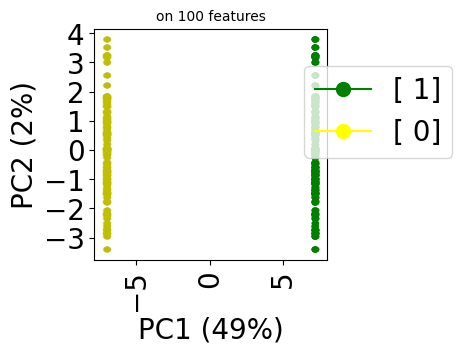

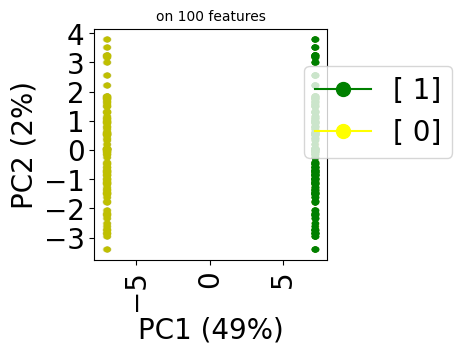

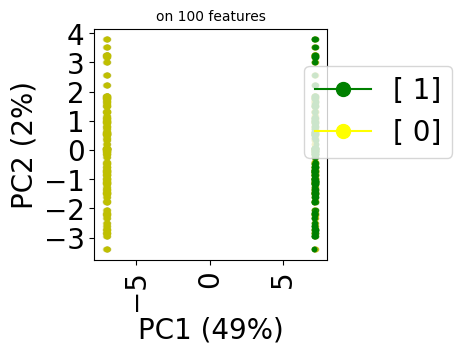

In [166]:
censoring_dt.visualize(withzeros=True, figsize=(3,3)) # we expect that for SVM it should be a hard instance
## however, PU methods should be OK, as unlabeled negatives are clearly different from (un)labeled positives
train_dataset.visualize(withzeros=True, figsize=(3,3)) # 80% of the dataset
test_dataset.visualize(withzeros=True, figsize=(3,3)) # 20% of the dataset

In [167]:
## test performance (to check for overfitting)
predictions_test = np.copy(scores_test)
predictions_test[:,2] = (scores_test[:,2].ravel()>0.5).astype(int)
## Validate the model
metrics_test, _ = compute_metrics(scores_test, predictions_test, test_dataset, ignore_zeroes=False)
metrics_test

,Avg. across users,Std
AUC,0.597356,0.143397
F_1.0,0.102612,0.068838


In [168]:
scores_clip = np.copy(scores_test[:,2].flatten())
scores_clip[scores_clip<0] = 0
scores_clip[scores_clip>1] = 1
[f(scores_test[:,2].flatten()) for f in [np.min, np.mean, np.max]]

[0.06640225293146566, 0.6536912947329837, 3.1463078887195346]

In [169]:
from benchscofi.utils import prior_estimation
reload(prior_estimation)

[e1,pi1], [e2,pi2], [e3,pi3] = [
    prior_estimation.data_aided_estimation(scores_clip, test_dataset, estimator_type=i) for i in [1,2,3]
 ]

pd.DataFrame(
    [
        [e1, e2, e3, pi1, pi2, pi3],
        [true_args_censoring["c"]]*3+[true_args_censoring["pi"]]*3,
    ]
, index=["Estimated", "True"], columns=["e1", "e2", "e3", "pi1", "pi2", "pi3"])

,e1,e2,e3,pi1,pi2,pi3
Estimated,1.0,0.000204,1.0,0.000098,0.479801,0.000098
True,0.4,0.400000,0.4,0.500000,0.500000,0.500000


Surprisingly enough, the corresponding estimator (type $2$) for $\pi$ is not too bad (see below), *i*.*e*.,
$$\hat{\pi}_2 := \frac{1}{|\mathcal{V}|}\sum_{(v,y) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+ \approx \mathbb{E}_{(v,y) \sim p}[y]\;.$$
The other estimators are super bad though.

Test 1, pi=0.100000, pi_hat=0.099064
Test 2, pi=0.200000, pi_hat=0.197983
Test 3, pi=0.300000, pi_hat=0.254488
Test 4, pi=0.400000, pi_hat=0.335954
Test 5, pi=0.500000, pi_hat=0.479801
Test 6, pi=0.600000, pi_hat=0.634422
Test 7, pi=0.700000, pi_hat=0.747837
Test 8, pi=0.800000, pi_hat=0.868552
Test 9, pi=0.900000, pi_hat=0.953412


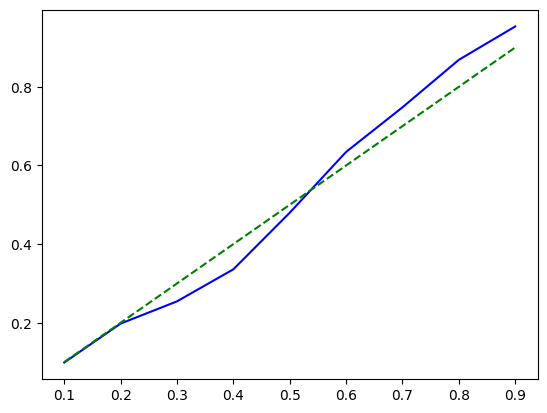

In [172]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

## One could also have more precise estimates by iterating on several random seeds (here we always consider rseed)
def test_estimator2(pi_true):
    pi_hats = []
    for i, pi in enumerate(pi_true):
        censoring_params_pi = {}
        censoring_params_pi.update(true_args_censoring)
        censoring_params_pi.update(synthetic_params)
        censoring_params_pi.update({'pi': pi})
        censoring_dt_pi = stanscofi.datasets.Dataset(**generate_Censoring_dataset(**censoring_params_pi)[0])
        _, _, scores_test_pi, _, test_dataset_pi = train_classifier(censoring_dt_pi, show_plots=False)
        scores_clip_pi = np.copy(scores_test_pi[:,2].flatten())
        scores_clip_pi[scores_clip_pi<0] = 0
        scores_clip_pi[scores_clip_pi>1] = 1
        _, pi_hat = prior_estimation.data_aided_estimation(scores_clip_pi, test_dataset_pi, estimator_type=2)
        pi_hats.append(pi_hat)
        print("Test %d, pi=%f, pi_hat=%f" % (i+1, pi, pi_hat))
    R = r2_score(pi_true, pi_hats)
    plt.plot(pi_true, pi_hats, "b-", label="estimation (R^2=%f)" % R)
    plt.plot(pi_true, pi_true, "g--", label="target")
    plt.xlabel(r"$\pi$")
    plt.ylabel(r"$\hat{\pi}$")
    plt.legend()
    plt.show()
    
test_estimator2([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

Let us test this estimator on the real-life dataset

In [65]:
from stanscofi.validation import compute_metrics, plot_metrics
from stanscofi.preprocessing import preprocessing_routine
#from stanscofi.training_testing import traintest_validation_split
from sklearn.model_selection import cross_validate ## works when no PU learning...
from sklearn.model_selection import StratifiedKFold ## otherwise we end up with single-class batches
from sklearn.metrics import roc_auc_score

from stanscofi.models import create_scores
from sklearn.svm import SVC ## SVM alone dies on PU learning (as expected)
#from benchscofi.PulearnWrapper import PulearnWrapper
from pulearn import ElkanotoPuClassifier ## let's be conservative and directly use the implementation in pulearn

def train_classifier_reallife(dataset, test_size=0.2, subset=100, red_size=0.1, show_plots=False):
    ## Model parameters: PU learn
    model = ElkanotoPuClassifier(**{
                "estimator": SVC(C=10, kernel='rbf', gamma=0.4, probability=True),
                "hold_out_ratio": 0.2,
            })
    
    ## Dimension reduction
    ## Select Top-k in terms of cross-sample variance
    data_args_red = stanscofi.utils.load_dataset(dataset_name, dataset_folder)
    var = np.concatenate((data_args_red["users"].values,data_args_red["items"]), axis=1).var(axis=1)
    features = np.argsort(-var)[:subset]
    data_args_red["users"] = data_args_red["users"].iloc[features,:]
    data_args_red["items"] = data_args_red["items"].iloc[features,:]
    data_args_red.update({"same_item_user_features": True})
    red_real_dataset = stanscofi.datasets.Dataset(**data_args_red)
    ## Supervised learning
    #from umap import UMAP
    #X, y, _,_,_ = preprocessing_routine(red_real_dataset, "same_feature_preprocessing")
    #with np.errstate(invalid="ignore"):
    #    umap_model = UMAP({'n_neighbors': 10, "min_dist":0.1, "metric":"correlation"})
    #    dimred_X = umap_model.fit_transform(X, y) ## run classifiers on this
    
    ## Random split
    from sklearn.model_selection import train_test_split
    X = np.array([[j,i] for i,j in np.argwhere(np.ones(red_real_dataset.ratings_mat.shape))])
    y = (red_real_dataset.ratings_mat.ravel()>0).astype(int) #censoring setting has no negatives
    ## Reduction #samples
    if (red_size<1):
        _, X_red, _, y_red = train_test_split(X, y, test_size=red_size, 
                            random_state=rseed, shuffle=True, stratify=y)
    else:
        X_red = X
        y_red = y
    X_train, X_test, y_train, y_test = train_test_split(X_red, y_red, test_size=test_size, 
                            random_state=rseed, shuffle=True, stratify=y_red)
    train_set = np.asarray(np.concatenate((X_train, y_train.reshape(-1,1)),axis=1), dtype=int)
    test_set = np.asarray(np.concatenate((X_test, y_test.reshape(-1,1)),axis=1), dtype=int)
    train_dataset = red_real_dataset.get_folds(train_set)
    test_dataset = red_real_dataset.get_folds(test_set)
    
    ## Preprocessing and fitting on the training set
    X_train, y_train, _,_,_ = preprocessing_routine(train_dataset, "same_feature_preprocessing")
    y_train = (y_train>0).astype(int)
    #model.fit(X_train,y_train) ## it overfits (as expected)
    ## K-fold Cross-validation (to avoid overfitting)
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scores = cross_validate(model, X_train, y_train, cv=5, scoring='roc_auc_ovr_weighted', 
                            return_estimator=True)
    model = scores["estimator"][np.argmax(scores['test_score'])]

    ## Predict (training set)
    scores_train = model.predict_proba(X_train).ravel()
    predictions_train = (scores_train>0.5).astype(int)
    
    ## Validate the model (training set)
    metric_train = roc_auc_score(y_train, scores_train, average="weighted", multi_class="ovr")

    X_test, y_test, _,_,_ = preprocessing_routine(test_dataset, "same_feature_preprocessing")
    scores_test = model.predict_proba(X_test).ravel()
    return metric_train, model, scores_test, train_dataset, test_dataset

In [ ]:
subset=2000
metric_RL, model, scores_test_RL, train_dataset_RL, test_dataset_RL = train_classifier_reallife(real_dataset,
                                                                    test_size=0.2, subset=subset, red_size=1)
print("%d known ratings, %d features" % (train_dataset_RL.ratings.shape[0], subset))
"AUC=%f" % metric_RL

In [ ]:
print("%d known ratings, %d features" % (test_dataset_RL.ratings.shape[0], subset))
X_test, y_test, _,_,_ = preprocessing_routine(test_dataset_RL, "same_feature_preprocessing")
scores_test = model.predict_proba(X_test).ravel()
metric_test_RL = roc_auc_score(y_test, scores_test, average="weighted", multi_class="ovr")
"AUC=%f" % metric_test_RL

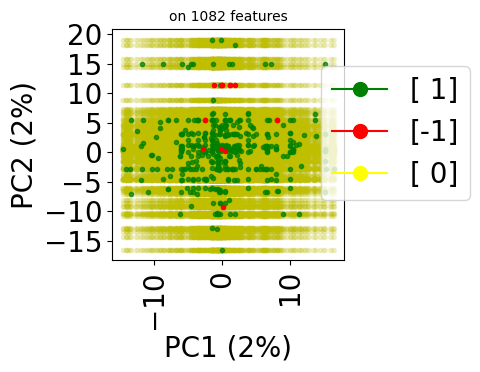

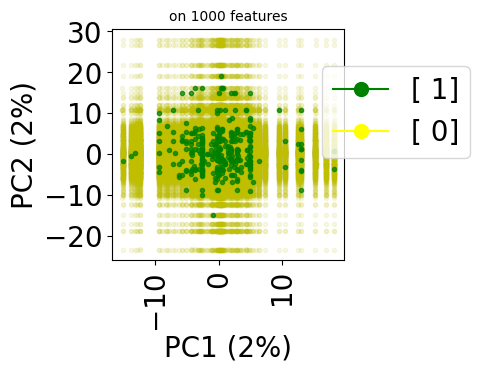

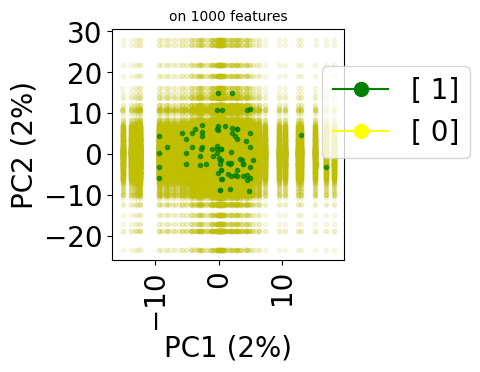

In [70]:
real_dataset.visualize(withzeros=True, figsize=(3,3)) # we expect that it should be a hard instance
train_dataset_RL.visualize(withzeros=True, figsize=(3,3)) # 80% of the dataset
test_dataset_RL.visualize(withzeros=True, figsize=(3,3)) # 20% of the dataset

In [ ]:
#scores_clip_pi = np.copy(scores_test_pi)
#scores_clip_pi[scores_clip_pi<0] = 0
#scores_clip_pi[scores_clip_pi>1] = 1
#_, pi_hat = prior_estimation.data_aided_estimation(scores_clip_pi, test_dataset_pi, estimator_type=2)
#metrics, model, scores = train_classifier(real_dataset, synthetic=False, show_plots=False)
#metrics

## test performance (to check for overfitting)
#predictions_test = np.copy(scores_test)
#predictions_test[:,2] = (scores_test[:,2].ravel()>0.5).astype(int)
## Validate the model
#metrics_test, _ = compute_metrics(scores_test, predictions_test, test_dataset, ignore_zeroes=False)
#metrics_test

## 3. Class prior estimation methods with Bayes regret approach

**In the case-control setting:**  **[1, Theorem $4$]** shows that if the supports for $p_+$ and $p_-$ are different
$$\hat{\pi} = -\lim_{\substack{\alpha \rightarrow 1\\ \alpha < 1}}\frac{\partial}{\partial \alpha}\inf_{\theta \in \Theta} \left\{  \underbrace{\mathcal{R}_\text{0-1}(\theta)}_\text{Bayes regret} \mid \mathbb{E}_{v \sim p_-}\ell_{0-1}(C_\theta(v),-1) \leq \alpha \right\}(\alpha)\;.$$

The issue is that the equation shown above can't be computed exactly in practice. As mentioned in **[2]**, a possible approach to approximate $\hat{\pi}$ is to regress a specific model (given in **[2]**) on the points of the corresponding ROC curve, and use the fitted model to extract the slope at the right-hand side of the curve, which is $\hat{\pi}$.

**[1]** Scott, Clayton, and Gilles Blanchard. "Novelty detection: Unlabeled data definitely help." Artificial intelligence and statistics. PMLR, 2009.

**[2]** Sanderson, Tyler, and Clayton Scott. "Class proportion estimation with application to multiclass anomaly rejection." Artificial Intelligence and Statistics. PMLR, 2014.

In [18]:
from benchscofi.utils import prior_estimation
reload(prior_estimation)

_, _, scores_test_pi, _, test_dataset_pi = train_classifier(casecontrol_dt, show_plots=False)
print(true_args_casecontrol["pi"])
pi_star = [
    prior_estimation.roc_aided_estimation(scores, predictions, casecontrol_dt, ignore_zeroes=False, 
                                                regression_type=i) for i in [1,2]
]
pi_star

src/benchscofi/utils/prior_estimation.py:84: RuntimeWarning: divide by zero encountered in log
  return -2*np.sum( np.multiply(mean_tprs, np.log(f(base_fprs))) + np.multiply(1-mean_tprs, np.log(1-f(base_fprs))) )
src/benchscofi/utils/prior_estimation.py:84: RuntimeWarning: invalid value encountered in multiply
  return -2*np.sum( np.multiply(mean_tprs, np.log(f(base_fprs))) + np.multiply(1-mean_tprs, np.log(1-f(base_fprs))) )
src/benchscofi/utils/prior_estimation.py:86: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(binomial_deviance, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
src/benchscofi/utils/prior_estimation.py:73: RuntimeWarning: divide by zero encountered in divide
  return lambda x : (1-gamma)*np.power(1+Delta*(1/np.power(alpha,mu)-1), -1/mu)+gamma*alpha
src/benchscofi/utils/prior_estimation.py:84: RuntimeWarning: divide by zero encountered in log
  return -2*np.sum( np.multiply(mean_tprs, np.log(f(base_fprs))) 

[1.0, 1.0]

TODO penalized divergences

In [32]:
pi_hat = [prior_estimation.divergence_aided_estimation(synthetic_dataset_val, "meanimputation_standardize", lmb=1., 
                                            sigma=1., divergence_type=div) for div in ["L1-distance","Pearson"]]
pi_hat 

ValueError: shapes (2,) and (21,) not aligned: 2 (dim 0) != 21 (dim 0)